In [1]:
import pickle
import numpy as np
from scipy import sparse
from ripser import ripser
import matplotlib.pyplot as plt
from datetime import datetime
from skimage.transform import resize
import os
from PIL import Image, ImageOps
import cv2


from sklearn.model_selection import train_test_split
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from persim import PersistenceImager
import collections
collections.Iterable = collections.abc.Iterable

In [2]:
def lower_star_img(img):
    """
    Construct a lower star filtration on an image
    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data
    Returns
    -------
    I: ndarray (K, 2)
        A 0-dimensional persistence diagram corresponding to the sublevelset filtration
    """
    m, n = img.shape
    idxs = np.arange(m * n).reshape((m, n))
    I = idxs.flatten()
    J = idxs.flatten()
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs
    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue
            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]
            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))

    sparseDM = sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))
    return ripser(sparseDM, distance_matrix=True, maxdim=1)["dgms"]

def get_dgms(img_arr, hom_dim = 1):
    # Initialize array to store all dgms
    num_images = img_arr.shape[2]
    dgms_arr = []
    
    # Iterate through all images, compute sublevel set filtration
    # for each image and corresponding pers. img for given hom. dim.
    for i in range(num_images):
        dgm = lower_star_img(img_arr[:,:,i])[hom_dim]
        dgms_arr.append(dgm)
    return dgms_arr

In [3]:
with open('all_nonempty_dgms.pkl', 'rb') as f:
    all_dgms = pickle.load(f)
with open('cleaned_labels.pkl', 'rb') as f:
    all_labels = pickle.load(f)

In [73]:
# with open('raw_pimgs.pkl', 'wb') as f:
#     pickle.dump(pimgs, f)
# with open('raw_pimgs.pkl', 'rb') as f:
#     pimgs = pickle.load(f)

In [29]:
# with open('flat_stacked_pimgs.pkl', 'wb') as f:
#     pickle.dump(stacked_pimgs, f)

In [4]:
with open('flat_stacked_pimgs.pkl', 'rb') as f:
    stacked_pimgs = pickle.load(f)

In [4]:
# Initialize a PersistenceImager with default parameters
pimgr = PersistenceImager(pixel_size=9, birth_range=(0.0, 1.0), pers_range=(0.0, 1.0))

# Fit the imager to the data to determine suitable ranges
pimgs = pimgr.fit_transform(all_dgms)

In [17]:
pimgr_params = str(pimgr)
pimgr_params
# with open('pimgr_params.pkl', 'wb') as f:
#     pickle.dump(pimgr_params, f)

"PersistenceImager(birth_range=(-3.5, 257.5), pers_range=(-2.5, 258.5), pixel_size=9, weight=persistence, weight_params={'n': 1.0}, kernel=gaussian, kernel_params={'sigma': [[1.0, 0.0], [0.0, 1.0]]})"

In [11]:
# flat_pimgs = [pimg.flatten() for pimg in pimgs]
# stacked_pimgs = np.vstack(flat_pimgs)

X = stacked_pimgs
y = all_labels

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y) 

rf = RandomForestClassifier(n_estimators=200, max_depth=30, max_features='sqrt', 
                            min_samples_leaf=1, random_state=4400) 

start_time = time.time()

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

elapsed_time = time.time() - start_time
print(classification_report(y_test, rf_pred))
print(f'Time taken: {elapsed_time:.2f} seconds')

              precision    recall  f1-score   support

           0       0.83      0.29      0.43       132
           1       0.57      0.62      0.60       339
           2       0.57      0.80      0.67       421
           3       0.72      0.56      0.63       246
           4       0.77      0.51      0.61       172

    accuracy                           0.62      1310
   macro avg       0.69      0.56      0.59      1310
weighted avg       0.65      0.62      0.61      1310

Time taken: 20.00 seconds


In [20]:
importance_sum = 0
for i, idx in enumerate(feature_indices[:9]):
    print(f"{i + 1}. Feature {idx}: Importance = {feature_importances[idx]}")
    importance_sum+=feature_importances[idx]
print(importance_sum*100)

1. Feature 377: Importance = 0.01137170700618339
2. Feature 348: Importance = 0.01110131308805355
3. Feature 493: Importance = 0.011006571418361605
4. Feature 203: Importance = 0.01088204586659209
5. Feature 261: Importance = 0.010686882317678418
6. Feature 406: Importance = 0.010653488338624773
7. Feature 464: Importance = 0.010645163341437775
8. Feature 319: Importance = 0.01063151167153144
9. Feature 290: Importance = 0.01058723862047141
9.756592166893446


In [19]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create an array of indices corresponding to feature importance ranking
feature_indices = np.argsort(feature_importances)[::-1]
feature_indices = [index for index in feature_indices if feature_importances[index] >= 0.01]
print(feature_indices)

# Display the most important features in descending order
print("Feature ranking:")
for i, idx in enumerate(feature_indices):
    print(f"{i + 1}. Feature {idx}: Importance = {feature_importances[idx]}")

[377, 348, 493, 203, 261, 406, 464, 319, 290, 349, 320, 174, 232, 435, 291, 262, 378, 233, 204]
Feature ranking:
1. Feature 377: Importance = 0.01137170700618339
2. Feature 348: Importance = 0.01110131308805355
3. Feature 493: Importance = 0.011006571418361605
4. Feature 203: Importance = 0.01088204586659209
5. Feature 261: Importance = 0.010686882317678418
6. Feature 406: Importance = 0.010653488338624773
7. Feature 464: Importance = 0.010645163341437775
8. Feature 319: Importance = 0.01063151167153144
9. Feature 290: Importance = 0.01058723862047141
10. Feature 349: Importance = 0.01052757018026114
11. Feature 320: Importance = 0.010499959301828397
12. Feature 174: Importance = 0.010471643901450419
13. Feature 232: Importance = 0.01041308277849494
14. Feature 435: Importance = 0.010350510767968543
15. Feature 291: Importance = 0.010245140813223171
16. Feature 262: Importance = 0.010203570970513805
17. Feature 378: Importance = 0.010155740275461534
18. Feature 233: Importance = 0.0101

In [429]:
ordered_pi_indices = np.unravel_index(feature_indices, (29,29))
ordered_pi_indices = list(zip(ordered_pi_indices[0], ordered_pi_indices[1]))
ordered_pi_indices

[(13, 0),
 (12, 0),
 (17, 0),
 (7, 0),
 (9, 0),
 (14, 0),
 (16, 0),
 (11, 0),
 (10, 0),
 (12, 1),
 (11, 1),
 (6, 0),
 (8, 0),
 (15, 0),
 (10, 1),
 (9, 1),
 (13, 1),
 (8, 1),
 (7, 1)]

In [22]:
pimgr_params

"PersistenceImager(birth_range=(-3.5, 257.5), pers_range=(-2.5, 258.5), pixel_size=9, weight=persistence, weight_params={'n': 1.0}, kernel=gaussian, kernel_params={'sigma': [[1.0, 0.0], [0.0, 1.0]]})"

In [24]:
birth_range = (-3.5, 257.5)
pers_range = (-2.5, 258.5)
delta_b = (birth_range[1] - birth_range[0]) / 29
delta_p = (pers_range[1] - pers_range[0]) / 29

# for a given pixel of interest at (row, col), e.g. at (13, 0), the corresponding region in the persistence
# diagram will have bottom left (cartesian) coordinates of (col*delta_b, (29 - row)*delta_p), e.g coords (0, 144)
# Centroid coords. will be ((col+0.5)*delta_b, (29-row+0.5)*delta_p)), e.g., (4.5, 148.5)

9.0

In [56]:
def pers_pt_centroid_and_bottom_left_coords(pixel_idx, birth_range=(-3.5, 257.5), 
                                            pers_range=(-2.5, 258.5), pers_img_shape=(29, 29)):
    """
    Computes coordinates of bottom left point and centroid point of rectangular area
    generated (in persistence diagram) by given pixel (in persistence image)
    Parameters
    ----------
    pixel_idx: tuple of (row, col) index of pixel of interest
    birth_range: tuple of births range such that all pers. pairs (in dgm) are minimally
                 enclosed across pers. pairs from one or more pers. dgms.
    pers_range: tuple of persistences range such that all pers. pairs (in dgm) are minimally
                enclosed across pers. pairs from one or more pers. dgms.
    pers_img_shape: tuple of pers. img's dimensions
    
    """
    # Compute scale factor to go images' axes to persistence diagrams' axes
    delta_b = (birth_range[1] - birth_range[0]) / pers_img_shape[1]
    delta_p = (pers_range[1] - pers_range[0]) / pers_img_shape[0]
    
    # Compute coords. of bottom left point of rectangle generated (in persistence diagram)
    # by the given pixel (in persistence image) 
    bottom_left_coords = (pixel_idx[1] * delta_b, (pers_img_shape[0] - pixel_idx[0]) * delta_p)
    
    # Compute coords. of centroid of rectangle generated
    centroid_coords = ((pixel_idx[1] + 0.5) * delta_b, (pers_img_shape[0] - pixel_idx[0] + 0.5) * delta_p)
    
    return bottom_left_coords, centroid_coords



bottom_left_coords, centroid_coords = pers_pt_centroid_and_bottom_left_coords((13, 0))

(0.0, 144.0)
(4.5, 148.5)


In [122]:
tup = (0.0, 144.0)
tup[::-1]

(144.0, 0.0)

In [125]:
bl_coords, centroid_coords = [], []
for index in ordered_pi_indices:
    bl_coord, centroid_coord = pers_pt_centroid_and_bottom_left_coords(index)
    bl_coords.append(bl_coord[::-1])
    centroid_coords.append(centroid_coord[::-1])    

In [127]:
def bp_coords_to_bd_coords(coords):
    new_coords = []
    for idx in coords:
        new_coords.append((idx[0],  idx[1] + idx[0]))
    return new_coords

new_centroids = bp_coords_to_bd_coords(centroid_coords)
new_centroids

[(148.5, 153.0),
 (157.5, 162.0),
 (112.5, 117.0),
 (202.5, 207.0),
 (184.5, 189.0),
 (139.5, 144.0),
 (121.5, 126.0),
 (166.5, 171.0),
 (175.5, 180.0),
 (157.5, 171.0),
 (166.5, 180.0),
 (211.5, 216.0),
 (193.5, 198.0),
 (130.5, 135.0),
 (175.5, 189.0),
 (184.5, 198.0),
 (148.5, 162.0),
 (193.5, 207.0),
 (202.5, 216.0)]

In [134]:
arr=np.array(new_centroids)
arr

array([[148.5, 153. ],
       [157.5, 162. ],
       [112.5, 117. ],
       [202.5, 207. ],
       [184.5, 189. ],
       [139.5, 144. ],
       [121.5, 126. ],
       [166.5, 171. ],
       [175.5, 180. ],
       [157.5, 171. ],
       [166.5, 180. ],
       [211.5, 216. ],
       [193.5, 198. ],
       [130.5, 135. ],
       [175.5, 189. ],
       [184.5, 198. ],
       [148.5, 162. ],
       [193.5, 207. ],
       [202.5, 216. ]])

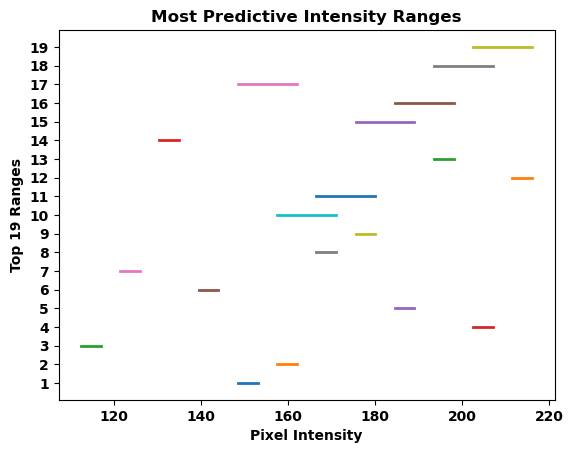

In [182]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot a line for each range
for i, (start, end) in enumerate(new_centroids):
    x_values = [start, end]
    y_values = [i + 1, i + 1]  # Y-values go up by one for each line
    ax.plot(x_values, y_values, linewidth=2)

# Set labels and title
ax.set_title('Most Predictive Intensity Ranges')
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Top 19 Ranges')

# Add y-axis ticks
ax.set_yticks(range(1, len(new_centroids) + 1))

# Show the plot
plt.show()

In [358]:
def display_original_vs_masked2(img, inten_ranges, output_filename='default_name', save=False):
    """
    Display original and masked image side-by-side. Masks image based on a given list of intensity ranges
    Parameters
    ----------
    img: image of interest (as an array)
    inten_ranges: list of predictive intensity ranges
    output_filename: file name to use when saving figure
    save: boolean to determine whether figure will be saved
    """
    
    # Initialize an empty mask with the same shape as the image
    mask = np.zeros_like(img, dtype=bool)

    # Iterate through the list of intensity ranges and apply masks with logical OR
    for lower, upper in inten_ranges:
        current_mask = np.logical_and(img >= lower, img <= upper)
        mask = np.logical_or(mask, current_mask)

    # Apply the final mask to the original image
    result_image = img * mask

    # Display the original and masked images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_image, cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')
    
    # Saving figure
    if save:
        plt.savefig(output_filename, dpi=200, bbox_inches='tight')
    plt.show()

In [171]:
new_centroids[:200000000]

[(148.5, 153.0),
 (157.5, 162.0),
 (112.5, 117.0),
 (202.5, 207.0),
 (184.5, 189.0),
 (139.5, 144.0),
 (121.5, 126.0),
 (166.5, 171.0),
 (175.5, 180.0),
 (157.5, 171.0),
 (166.5, 180.0),
 (211.5, 216.0),
 (193.5, 198.0),
 (130.5, 135.0),
 (175.5, 189.0),
 (184.5, 198.0),
 (148.5, 162.0),
 (193.5, 207.0),
 (202.5, 216.0)]

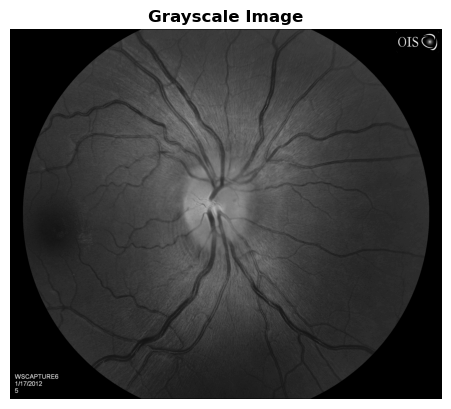

In [423]:
# Load the colored image
colored_image = cv2.imread(r"C:\Users\hafid\OneDrive\Documents\Classes\MATH4020 Project\PNGs\TDA from previous project\before_split\frisen_two\IIHTT_70043_01-17-2012_seven_months_005_OD_grade_2_fellow_ACZ.png")

# Convert the image to grayscale
grayscale_image = cv2.cvtColor(colored_image, cv2.COLOR_BGR2GRAY)

# Display the original and grayscale images side by side
# plt.figure(figsize=(10, 5))

plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()

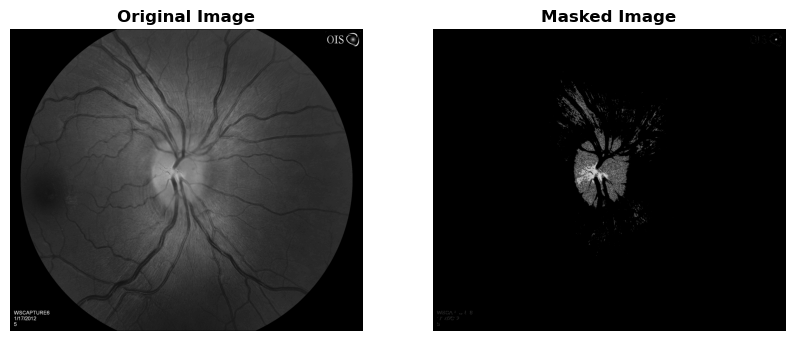

In [428]:
display_original_vs_masked2(grayscale_image, new_centroids[:19], output_filename='Selected_Grade2.png', save=True)

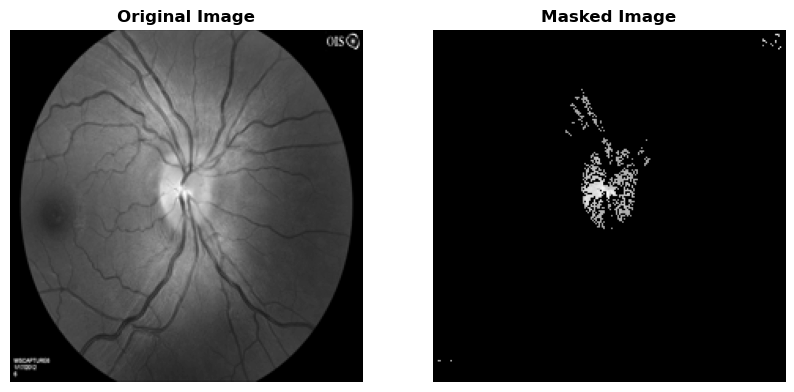

In [422]:
display_original_vs_masked2(f_twos[:,:,132], new_centroids[:19])

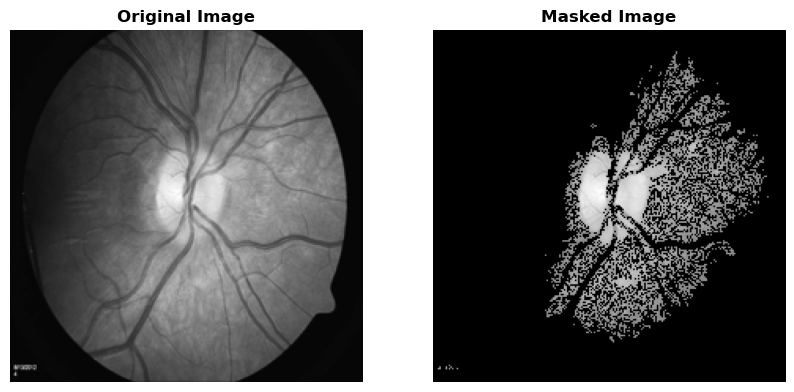

In [412]:
display_original_vs_masked2(f_ones[:,:,1200], new_centroids[:19])

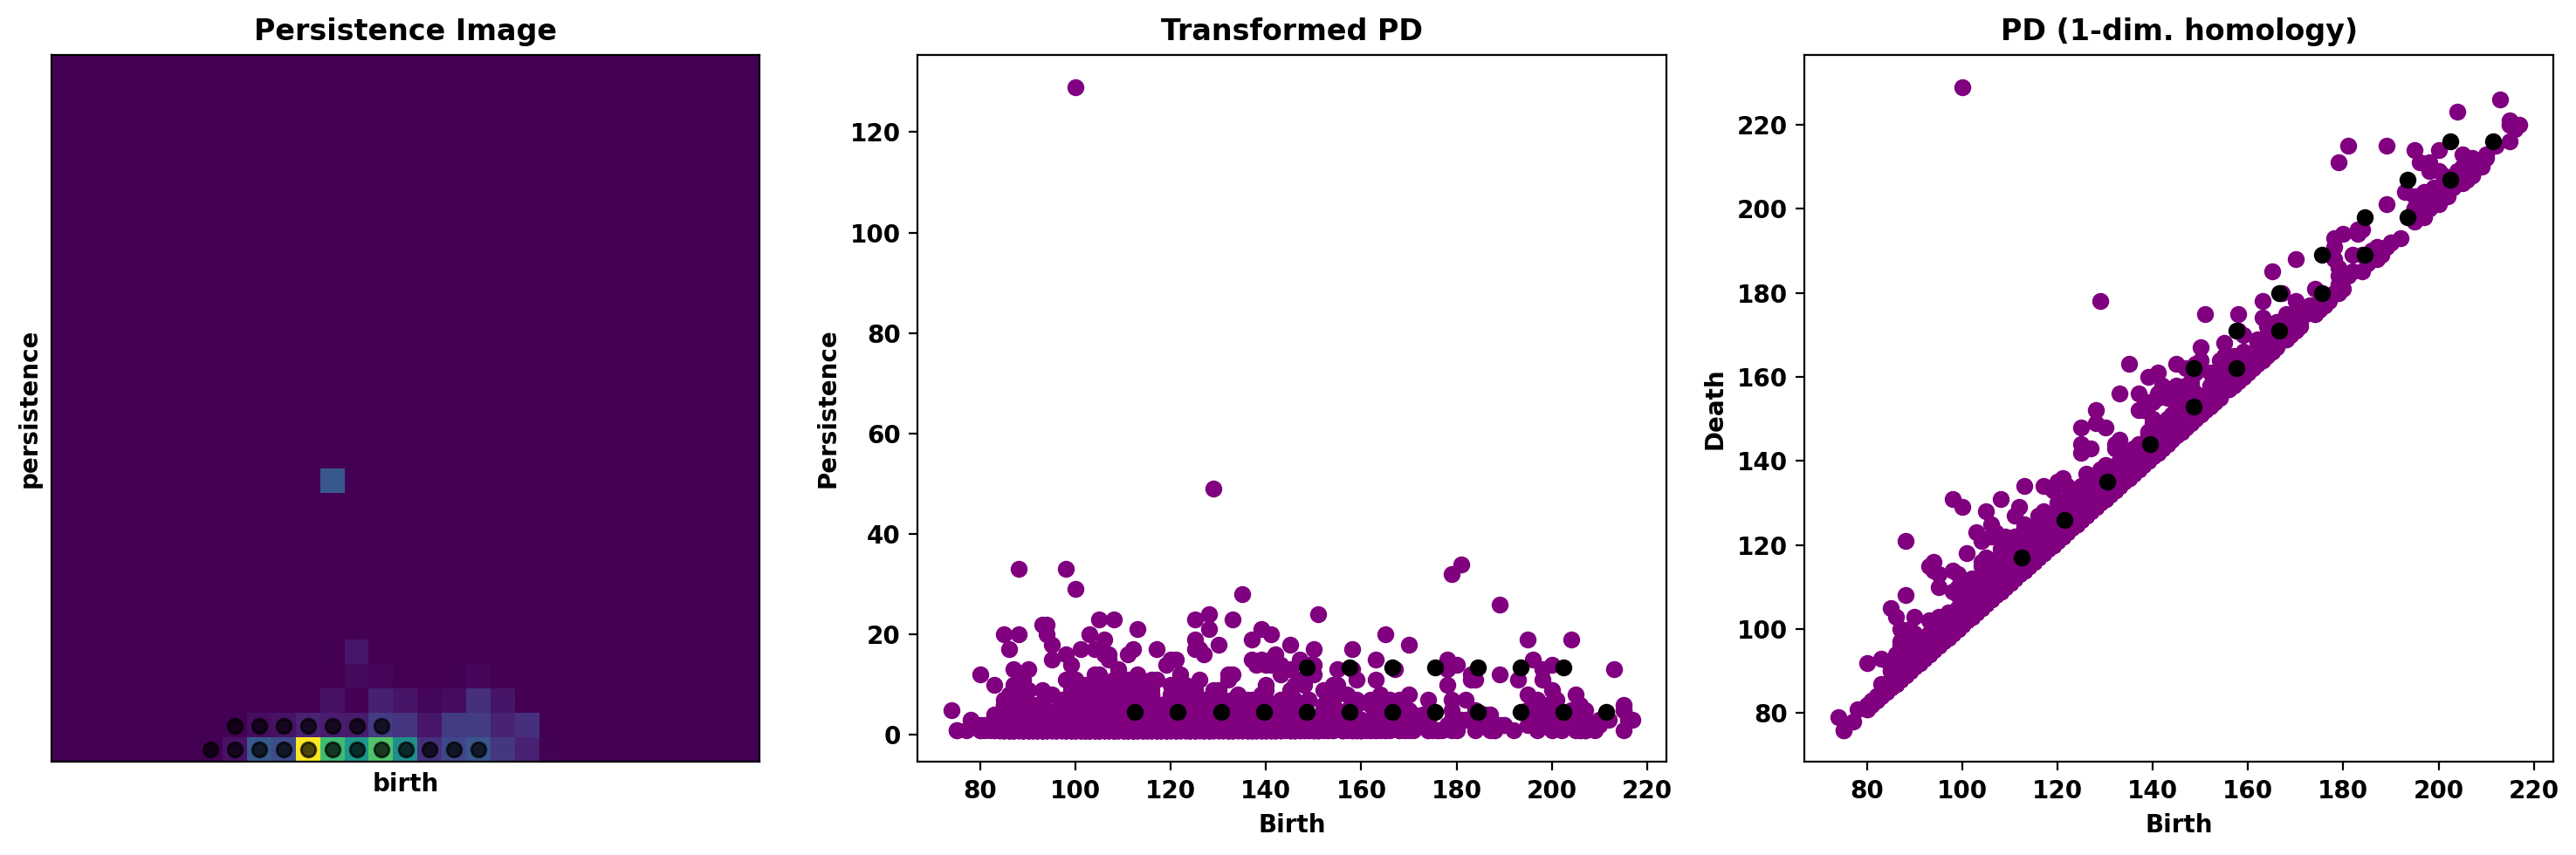

In [435]:
## dgm_test = dgms_ones[21]
dgm_test = dgms_fours_fives[5]
imp_arr = np.array(centroid_coords)
imp_arr2 = np.array(new_centroids)

idx_arr = np.array(ordered_pi_indices)

# Create subplots with equal column widths
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=200, gridspec_kw={'width_ratios': [1, 1, 1]})

image_axes = pimgr.plot_image(pimgs[5697], ax=axes[0])  # Pass the Axes object directly
axes[0].scatter(idx_arr[:, 0], idx_arr[:, 1], color='black', alpha=0.7)
axes[0].set_title('Persistence Image')

pers_coords = dgm_test[:, 1] - dgm_test[:, 0]
axes[1].scatter(dgm_test[:, 0], pers_coords, color='purple')
axes[1].scatter(imp_arr[:, 0], imp_arr[:, 1], color='black')
axes[1].set_title('Transformed PD')
axes[1].set_xlabel('Birth')
axes[1].set_ylabel('Persistence')

axes[2].scatter(dgm_test[:, 0], dgm_test[:, 1], color='purple')
axes[2].scatter(imp_arr2[:, 0], imp_arr2[:, 1], color='black')
axes[2].set_title('PD (1-dim. homology)')
axes[2].set_xlabel('Birth')
axes[2].set_ylabel('Death')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the entire figure locally
plt.savefig('PI-T(PD)-PD.png', dpi=200, bbox_inches='tight')

# Show the plots
plt.show()

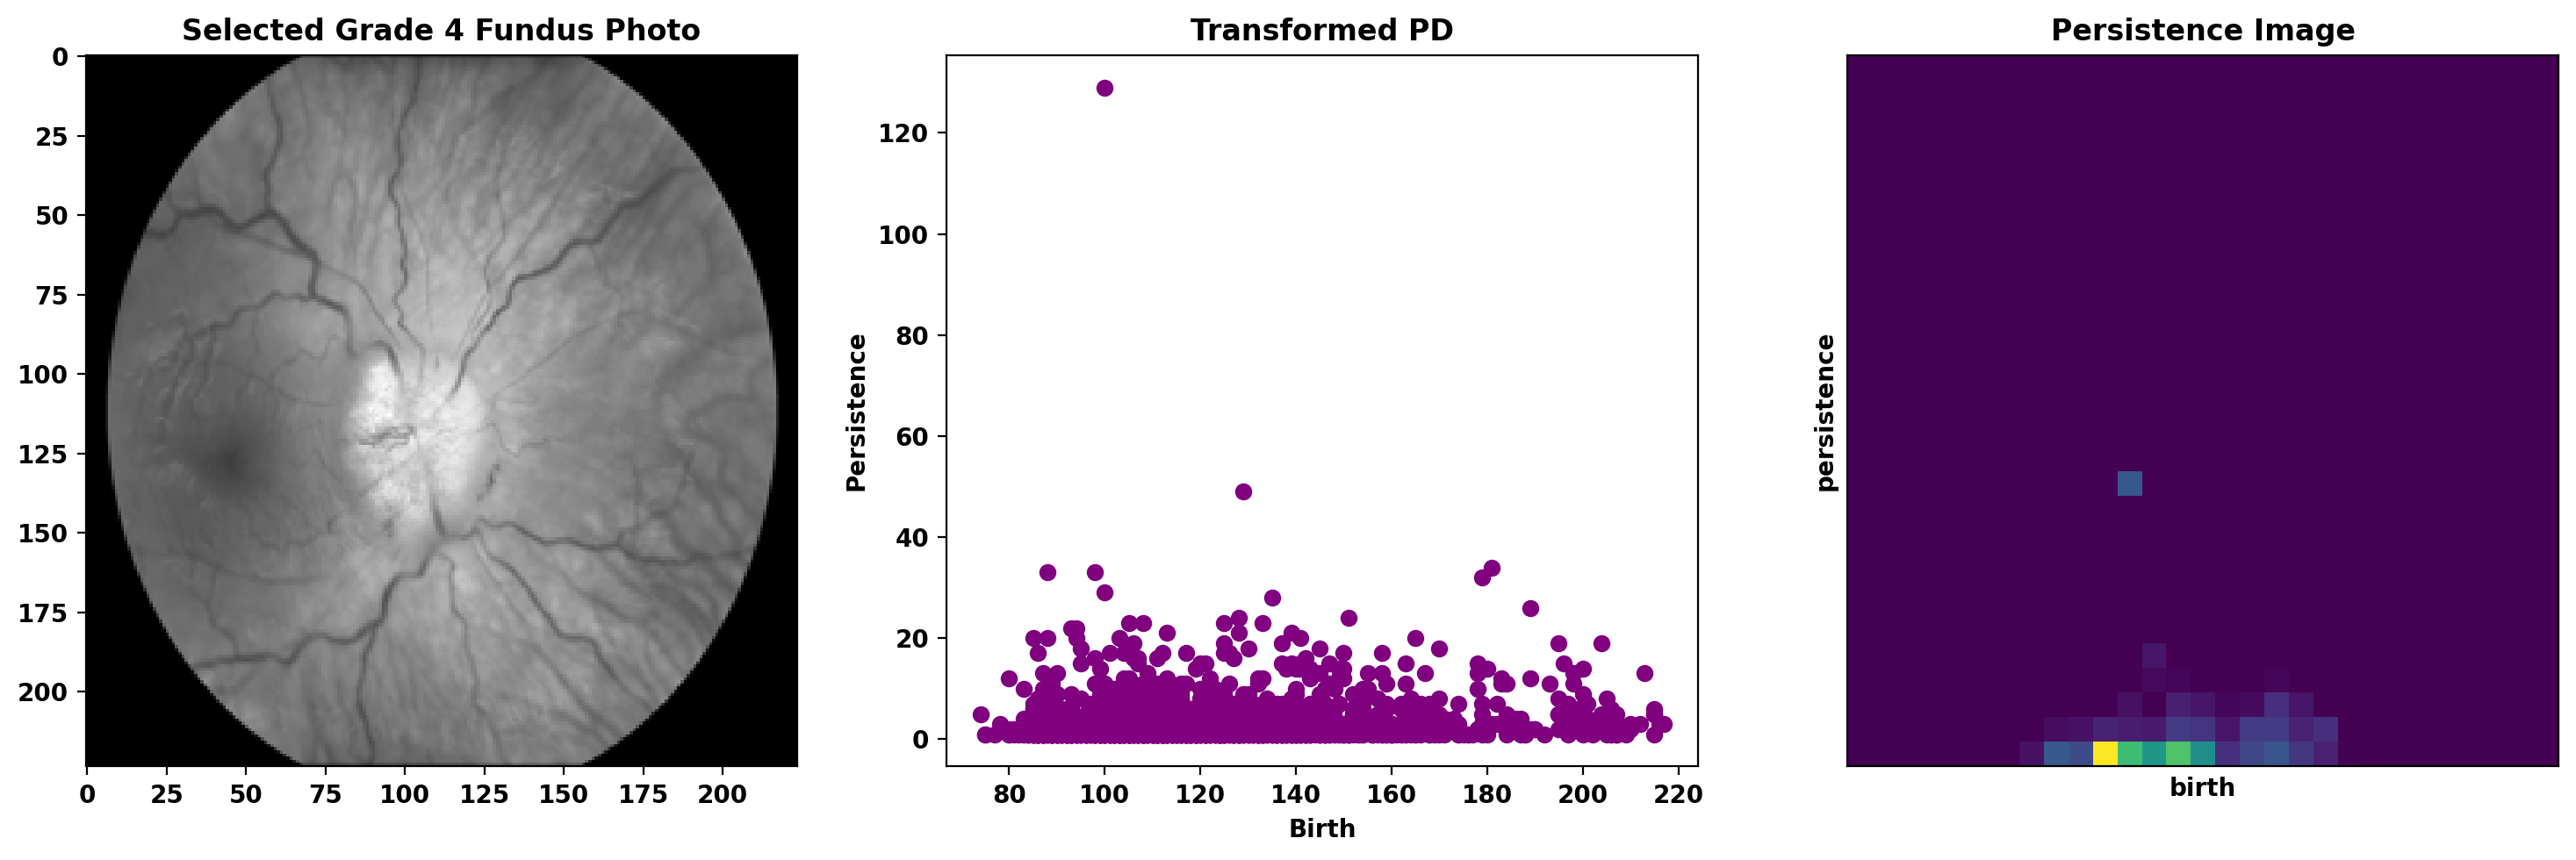

In [436]:
## dgm_test = dgms_ones[21]
dgm_test = dgms_fours_fives[5]
imp_arr = np.array(centroid_coords)
imp_arr2 = np.array(new_centroids)

idx_arr = np.array(ordered_pi_indices)

# Create subplots with equal column widths
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=200, gridspec_kw={'width_ratios': [1, 1, 1]})

axes[0].imshow(f_fours[:, :, 5], cmap='gray')
axes[0].set_title('Selected Grade 4 Fundus Photo')

pers_coords = dgm_test[:, 1] - dgm_test[:, 0]
axes[1].scatter(dgm_test[:, 0], pers_coords, color='purple')
axes[1].set_title('Transformed PD')
axes[1].set_xlabel('Birth')
axes[1].set_ylabel('Persistence')
                
image_axes = pimgr.plot_image(pimgs[5697], ax=axes[2])
axes[2].set_title('Persistence Image')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the entire figure locally
plt.savefig('Photo-T(PD)-PI.png', dpi=200, bbox_inches='tight')

# Show the plots
plt.show()

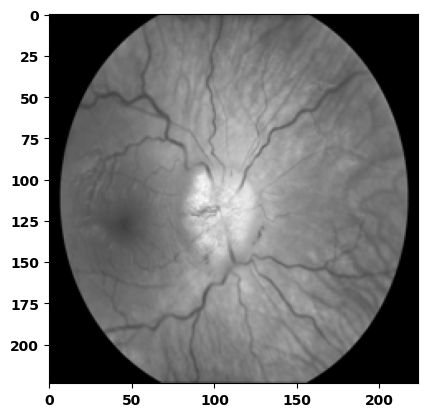

In [432]:
plt.imshow(f_fours[:,:,5], cmap='grey')
plt.show()

In [37]:
# Use numpy's unique function with return_counts=True
unique_values, counts = np.unique(y, return_counts=True)

# Create a dictionary to store the count of each digit
digit_counts = dict(zip(unique_values, counts))

# Print or use the resulting dictionary as needed
print(digit_counts)

{0: 659, 1: 1697, 2: 2107, 3: 1228, 4: 858}


In [38]:
dgms_zeros = all_dgms[0:659]
dgms_ones = all_dgms[659:2356]
dgms_twos = all_dgms[2356:4463]
dgms_threes = all_dgms[4463:5691]
dgms_fours_fives = all_dgms[5691:6549]

In [26]:
with open('frisen_fives_all.pkl', 'rb') as f:
    f_fives = pickle.load(f)
with open('frisen_fours_all.pkl', 'rb') as f:
    f_fours = pickle.load(f)    
with open('frisen_threes_all.pkl', 'rb') as f:
    f_threes = pickle.load(f)  
with open('cleaned_frisen_twos.pkl', 'rb') as f:
    f_twos = pickle.load(f)
with open('cleaned_frisen_ones.pkl', 'rb') as f:
    f_ones = pickle.load(f)      
with open('frisen_zeros.pkl', 'rb') as f:
    f_zeros = pickle.load(f)

f_fours_fives = np.concatenate((f_fours, f_fives), axis=2)
with open('frisen_fours_fives.pkl', 'wb') as f:
    pickle.dump(f_fours_fives, f)
with open('frisen_fours_fives.pkl', 'rb') as f:
    f_fours_fives = pickle.load(f)  

In [136]:
# Remove elements at specified indices along the third dimension
# indices_to_remove = [867, 868, 869, 870, 1242]
# f_ones_without_indices = np.delete(f_ones, indices_to_remove, axis=2)
# f_ones_without_indices.shape

(224, 224, 1697)

In [137]:
# indices_to_remove = [659, 660, 661, 662, 679, 680, 681, 682, 810, 811, 812, 813]
# f_twos_without_indices = np.delete(f_twos, indices_to_remove, axis=2)
# f_twos_without_indices.shape

(224, 224, 2107)

In [138]:
# with open('cleaned_frisen_ones.pkl', 'wb') as f:
#     pickle.dump(f_ones_without_indices, f)
# with open('cleaned_frisen_twos.pkl', 'wb') as f:
#     pickle.dump(f_twos_without_indices, f)

In [25]:
def display_original_vs_masked(img, lower_inten, max_inten, output_filename='default_name', save=False):
    
    # Create a binary mask for pixels within the specified intensity range
    mask = np.logical_and(img >= lower_inten, img <= max_inten)
    # mask2, mask3
    # adding masks
    # if entry in added masks is 0 do nothing, if more than 1 turn back to 1
    

    # Apply the mask to the original image
    result_image = img * mask

    # Display the original and masked images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_image, cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')
    
    if save:
        plt.savefig(output_filename)

    plt.show()